In [1]:
import os
print(os.getcwd())

work_directory_R = os.getcwd() + "/Results_ROC"
work_directory_C = os.getcwd() + "/Results_CM"
work_directory_P = os.getcwd() + "/ResultsPredicted"
Results_File = os.getcwd() + "/Metrics_Result.txt"

import shutil

## Try to remove tree; if failed show an error using try...except on screen
try:
    shutil.rmtree(work_directory_R)
    shutil.rmtree(work_directory_C)
    shutil.rmtree(work_directory_P)
    os.remove(Results_File)
except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))
    
import gc as g

# %reset
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)


import tensorflow as tf,keras
from keras import backend as K, optimizers, regularizers
# K.clear_session()

import pickle, sys,os,cv2, numpy as np, pandas as pd, scipy, seaborn as sns, json, joblib
from random import shuffle
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, ZeroPadding2D, merge
from keras.layers.merge import concatenate
from keras import utils as np_utils
from keras.regularizers import l2

from keras.optimizers import Adam,RMSprop,SGD
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator,array_to_img
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm

get_ipython().magic('matplotlib inline')
%matplotlib inline

from keras import layers
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix, roc_curve, auc, recall_score, precision_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from functools import partial
from sklearn import metrics
from collections import Counter
from itertools import cycle
from six.moves import cPickle as pickle
from scipy import interp
from skimage.feature import local_binary_pattern,hog
from skimage import data, exposure

import itertools
from time import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

print('Libraries Loaded')

tf.__version__
tf.test.is_built_with_cuda()

# GPU Check 1
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


D:\Taimoor_Datasets\Paper 2\WSI\Processed_Class_Wise\RESULTS_DIRECTORY_TRAIN_Dart_LUNG\Code_TSNE\Final
Error: D:\Taimoor_Datasets\Paper 2\WSI\Processed_Class_Wise\RESULTS_DIRECTORY_TRAIN_Dart_LUNG\Code_TSNE\Final/Results_ROC - The system cannot find the path specified.


Using TensorFlow backend.


Libraries Loaded


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5785335224963059792, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15152644096
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11767988271438374685
 physical_device_desc: "device: 0, name: Quadro RTX 5000, pci bus id: 0000:17:00.0, compute capability: 7.5"]

In [2]:
def load_pickle(data_file,q):
    print('\nTring to load pickle from %s' % data_file)
    with open(data_file, 'rb') as file:
        datasets = pickle.load(file)
        dataset = datasets['dataset']

    X_train = dataset['X_train']
    Y_train = dataset['Y_train']
    
    print('\nPickle Loaded Successfully!')
    
    del dataset

    if q==1:
        print('\nX_train shape:', X_train.shape)
        print('Y_train shape:', Y_train.shape)
    
    return X_train,Y_train

In [3]:
def save_pickle(x_train,y_train, data_file):
    print('\nTrying to save pickle to %s' % data_file)
    
    X_train = x_train
    Y_train = y_train
    del x_train,y_train
    
    # creating dictionary to store trian and test data
    datasets = {'dataset' : {'X_train': X_train,'Y_train': Y_train}}

    with open(data_file, 'wb') as file:
        pickle.dump(datasets, file, protocol=pickle.HIGHEST_PROTOCOL)
        del datasets # to free up memory.
        
    print('\nPickle Saved Successfully!')

In [4]:
option_D0a = 1

img_heighta,img_widtha = 40,40

if option_D0a==1:
    print("\n\n\n DataSet-1 \n")
    path  = "D://Taimoor_Datasets\Paper 2\WSI\Processed_Class_Wise\RESULTS_DIRECTORY_TRAIN_ICIAR/"
    
    # 111
    data_file = 'PICKLESNEW/DataSet_ICIAR_AE_Train.pickle'

    num_classes=4
    loss_a = 'categorical_crossentropy'
    
    X_train_,Y_train_ = load_pickle(data_file,1)
    
    unique, counts = np.unique(Y_train_, return_counts=True)
    abc= dict(zip(unique, counts))
    print(abc)
    for i in range(len(abc)):
        print('Class %d: %d' % (i, abc[i]))    





 DataSet-1 


Tring to load pickle from PICKLESNEW/DataSet_ICIAR_AE_Train.pickle

Pickle Loaded Successfully!

X_train shape: (32215, 40, 40, 3)
Y_train shape: (32215,)
{0: 3770, 1: 1655, 2: 25590, 3: 1200}
Class 0: 3770
Class 1: 1655
Class 2: 25590
Class 3: 1200


In [5]:
#Multi Class
print('\nx_train shape:', X_train_.shape)
print('y_train shape:', Y_train_.shape)

print("\n Train Portion \n")
unique, counts = np.unique(Y_train_, return_counts=True)
abc= dict(zip(unique, counts))
print(abc)
for i in range(len(abc)):
    print('Class %d: %d' % (i, abc[i]))

index = range(5425,27215)
X_train_ = np.delete(X_train_, index, axis=0)
Y_train_ = np.delete(Y_train_, index)
print('\nx_train shape:', X_train_.shape)
print('y_train shape:', Y_train_.shape)

print("\n Train Portion \n")
unique, counts = np.unique(Y_train_, return_counts=True)
abc= dict(zip(unique, counts))
print(abc)
for i in range(len(abc)):
    print('Class %d: %d' % (i, abc[i]))


x_train shape: (32215, 40, 40, 3)
y_train shape: (32215,)

 Train Portion 

{0: 3770, 1: 1655, 2: 25590, 3: 1200}
Class 0: 3770
Class 1: 1655
Class 2: 25590
Class 3: 1200

x_train shape: (10425, 40, 40, 3)
y_train shape: (10425,)

 Train Portion 

{0: 3770, 1: 1655, 2: 3800, 3: 1200}
Class 0: 3770
Class 1: 1655
Class 2: 3800
Class 3: 1200


In [6]:
if option_D0a==1:
    size1 = 0.80    #D1
#     size1 = 0.90    #D2
    X_train, X_testA, Y_train, Y_testA = train_test_split(X_train_, Y_train_, train_size=size1, random_state=106,shuffle=True)
    print('Train data:', X_train.shape,', Train labels:', Y_train.shape)
    print('Test data:', X_testA.shape,', Test labels:', Y_testA.shape)
    del X_train_, Y_train_
    
    print("\n Train Portion \n")
    unique, counts = np.unique(Y_train, return_counts=True)
    abc= dict(zip(unique, counts))
    print(abc)
    for i in range(len(abc)):
        print('Class %d: %d' % (i, abc[i]))

    print("\n Test Portion \n")
    unique, counts = np.unique(Y_testA, return_counts=True)
    abc= dict(zip(unique, counts))
    print(abc)
    for i in range(len(abc)):
        print('Class %d: %d' % (i, abc[i]))    
        

Train data: (8340, 40, 40, 3) , Train labels: (8340,)
Test data: (2085, 40, 40, 3) , Test labels: (2085,)

 Train Portion 

{0: 2990, 1: 1305, 2: 3076, 3: 969}
Class 0: 2990
Class 1: 1305
Class 2: 3076
Class 3: 969

 Test Portion 

{0: 780, 1: 350, 2: 724, 3: 231}
Class 0: 780
Class 1: 350
Class 2: 724
Class 3: 231


In [7]:
X_traina, Y_traina = X_train,Y_train
print('Train data:', X_traina.shape,', Train labels:', Y_traina.shape)

X_testa, Y_testa = X_testA,Y_testA
print('Test data:', X_testa.shape,', Test labels:', Y_testa.shape)

X_testaB, Y_testaB = X_testA,Y_testA


Train data: (8340, 40, 40, 3) , Train labels: (8340,)
Test data: (2085, 40, 40, 3) , Test labels: (2085,)


In [8]:
def HOGNLBPFeaturesN(totalData):

    # settings for HOG
    orientationsS = 16
    pixels_per_cellS = (14, 14)
    cells_per_blockS = (1, 1)
    
    # Extract the hog features
    list_hog_fd = []
    for feature in totalData:
#         feature = np.array(feature, dtype=np.uint8)
        feature = cv2.cvtColor(feature,cv2.COLOR_BGR2GRAY)
        fd = hog(feature, orientations=orientationsS, pixels_per_cell=pixels_per_cellS, cells_per_block=cells_per_blockS, visualize=False, block_norm='L2-Hys')
        list_hog_fd.append(fd)
    hog_features = np.array(list_hog_fd, 'float64')
        
    # settings for LBP
    radius = 2
    n_points = 8 * radius
    METHOD = 'uniform'
        
    # Extract the lbp features
    list_lbp_fd = []
    for feature in totalData:
        feature = cv2.cvtColor(feature,cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(feature, n_points, radius, METHOD)
        (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 255))
        lbp_features = lbp_hist.astype("float")
        list_lbp_fd.append(lbp_features)    
    lbp_features = np.array(list_lbp_fd, 'float64')

    list_X_train = []
    for feature in totalData:
        temp = feature.flatten()
        list_X_train.append(temp)

    X_train = np.array(list_X_train, 'float64')
    
    return lbp_features, hog_features, X_train


In [9]:
def save_pickle_N(x_train, y_train, data_file):
    print('\nTrying to save pickle to %s' % data_file)
    
    X_train = x_train
    Y_train = y_train
    del x_train, y_train
    
    # creating dictionary to store trian and test data
    datasets = {'dataset' : {'X_train': X_train, 'Y_train': Y_train}}

    with open(data_file, 'wb') as file:
        joblib.dump(datasets, file)

        del datasets # to free up memory.
    print('\nPickle Saved Successfully!')
    
def load_pickle_N(data_file,q):

    print('\nTring to load pickle from %s' % data_file)
    with open(data_file, 'rb') as file:
        datasets = joblib.load(file)
        dataset = datasets['dataset']

    print('\nPickle Loaded Successfully!')

    X_train = dataset['X_train']
    Y_train = dataset['Y_train']
    del dataset

    if q==1:
        print('\nX_train shape:', X_train.shape)
        print('Y_train shape:', Y_train.shape)
    
    return X_train,Y_train    

In [10]:
print('\nApplying Train Feature Extraction Opeartion')

work_directory_Pickles = os.getcwd() + "/PICKLESNEW"

if option_D0a==1:
    data_file_1 = '/AE_Train_ICIAR_R_N.pickle'
    data_file_2 = '/AE_Train_ICIAR_H_N.pickle'
    data_file_3 = '/AE_Train_ICIAR_L_N.pickle'
                
data_file_R = work_directory_Pickles + data_file_1
data_file_H = work_directory_Pickles + data_file_2        
data_file_L = work_directory_Pickles + data_file_3        

if not (os.path.exists(data_file_R)):
    totalData = X_traina
    totalData_Lables = Y_traina
    lbp_features, hog_features, X_traina = HOGNLBPFeaturesN(totalData)    
    lbp_features_labels, hog_features_labels, Y_traina = totalData_Lables, totalData_Lables, totalData_Lables 

    X_traina = X_traina.astype('float32')/255. 
    hog_features = hog_features.astype('float32')/255. 
    lbp_features = lbp_features.astype('float32')/255.

    print('\nRAW Features: ',X_traina.shape)
    print('RAW Features Labels: ',Y_traina.shape)
    save_pickle_N(X_traina, Y_traina, data_file_R)

    print('\nHOG Features: ',hog_features.shape)
    print('HOG Features Labels: ',hog_features_labels.shape)
    save_pickle_N(hog_features,hog_features_labels,data_file_H)

    print('\nLBP Features: ',lbp_features.shape)
    print('LBP Features Labels: ',lbp_features_labels.shape)
    save_pickle_N(lbp_features,lbp_features_labels,data_file_L)
    


Applying Train Feature Extraction Opeartion


In [11]:
print('\nApplying Test Feature Extraction Opeartion')
if option_D0a==1:
    data_file_1 = '/AE_Test_ICIAR_R_N.pickle'
    data_file_2 = '/AE_Test_ICIAR_H_N.pickle'
    data_file_3 = '/AE_Test_ICIAR_L_N.pickle'
        
data_file_R_T = work_directory_Pickles + data_file_1
data_file_H_T = work_directory_Pickles + data_file_2        
data_file_L_T = work_directory_Pickles + data_file_3  

if not (os.path.exists(data_file_R_T)):
    totalData = X_testa
    totalData_Lables = Y_testa
    lbp_featuresT, hog_featuresT, X_testa = HOGNLBPFeaturesN(totalData)    
    lbp_features_labelsT, hog_features_labelsT, Y_testa = totalData_Lables, totalData_Lables, totalData_Lables 

    X_testa = X_testa.astype('float32')/255. 
    hog_featuresT = hog_featuresT.astype('float32')/255. 
    lbp_featuresT = lbp_featuresT.astype('float32')/255.

    print('\nRAW Features: ',X_testa.shape)
    print('RAW Features Labels: ',Y_testa.shape)
    save_pickle_N(X_testa,Y_testa,data_file_R_T)

    print('\nHOG Features: ',hog_featuresT.shape)
    print('HOG Features Labels: ',hog_features_labelsT.shape)
    save_pickle_N(hog_featuresT,hog_features_labelsT,data_file_H_T)

    print('\nLBP Features: ',lbp_featuresT.shape)
    print('LBP Features Labels: ',lbp_features_labelsT.shape)
    save_pickle_N(lbp_featuresT,lbp_features_labelsT,data_file_L_T)    
    


Applying Test Feature Extraction Opeartion


In [12]:
def ActivationSelect(activation_function):
    if activation_function == 1:
        activation = 'relu'
    elif activation_function == 2:
        activation = 'sigmoid'
    elif activation_function == 3:
        activation = 'linear'
    elif activation_function == 4:
        activation = 'tanh'
    
    return activation

def Number_of_Neurons_Select(Neurons_Option,encoding_dim):
    if Neurons_Option == 1:
        Dimensions = encoding_dim
    elif Neurons_Option == 2:
        Dimensions = round(encoding_dim/2)
    elif Neurons_Option == 3:
        Dimensions = round(encoding_dim*2)
        
    return Dimensions

def HiddenLayerSelect(input_img,Hidden_Layers_Encoding_Dim,encoding_dim,S_Neurons_Options,activation_function,Name):

    activation_s = ActivationSelect(activation_function)
    
    if  Hidden_Layers_Encoding_Dim == 1:
        Option = Number_of_Neurons_Select(S_Neurons_Options,encoding_dim)
        h1 = Dense(Option, activation = activation_s)(input_img)
        encoded = Dense(encoding_dim, activation = activation_s,activity_regularizer=regularizers.l2(0.00001), name=Name)(h1)
        decoded_h1 = Dense(Option, activation = activation_s)(encoded)
        decoded = Dense(encoding_dim, activation = activation_s)(decoded_h1)

    elif Hidden_Layers_Encoding_Dim == 3:
        Option1 = Number_of_Neurons_Select(S_Neurons_Options,encoding_dim)
        h3 = Dense(Option1, activation = activation_s)(input_img)
        Option2 = Number_of_Neurons_Select(S_Neurons_Options,Option1)
        h2 = Dense(Option2, activation = activation_s)(h3)
        Option3 = Number_of_Neurons_Select(S_Neurons_Options,Option2)
        h1 = Dense(Option3, activation = activation_s)(h2)
        encoded = Dense(encoding_dim, activation = activation_s,activity_regularizer=regularizers.l2(0.00001), name=Name)(h1)
        decoded_h1 = Dense(Option3, activation = activation_s)(encoded)
        decoded_h2 = Dense(Option2, activation = activation_s)(decoded_h1)
        decoded_h3 = Dense(Option1, activation = activation_s)(decoded_h2)
        decoded = Dense(encoding_dim, activation = activation_s)(decoded_h3)
        
    return encoded, decoded

def _autoencoder(Hidden_Layers_Encoding_Dim, S_Neurons_Options,Number_of_Neurons, X_train, X_train_, X_test, X_test_,activation_function,Mode,epochs_, batch_size_,Name,optimizer):
    encoding_dim = Number_of_Neurons
    input_img = Input(shape=(Number_of_Neurons,))            
    encoded, decoded = HiddenLayerSelect(input_img,Hidden_Layers_Encoding_Dim,encoding_dim,S_Neurons_Options,activation_function,Name)
    
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    autoencoder.compile(loss='mse', optimizer=optimizer)
    
    if Mode==0:
        with tf.device('/device:CPU:0'):
            autoencoder_train_X = autoencoder.fit(X_train, X_train, batch_size=batch_size_,epochs= epochs_,shuffle=True,verbose=1,validation_data=(X_test, X_test_))
    elif Mode==1:
        with tf.device('/device:GPU:0'):
            autoencoder_train_X = autoencoder.fit(X_train, X_train, batch_size=batch_size_,epochs= epochs_,shuffle=True,verbose=1,validation_data=(X_test, X_test_))
    
    loss = autoencoder_train_X.history['loss']
    val_loss = autoencoder_train_X.history['val_loss']
    epochs = range(epochs_)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    return autoencoder, encoder


In [13]:
def my_train_test_split(X1,X2,X3, Y1,Y2,Y3, train_size):
    """return X_train, Y_train, X_test, Y_test"""
    n = X1.shape[0]
    split = int(n * train_size)
    index = np.arange(n)
    np.random.shuffle(index)
    
    return X1[index[:split]], X2[index[:split]], X3[index[:split]], Y1[index[:split]], Y2[index[:split]], Y3[index[:split]], X1[index[split:]], X2[index[split:]], X3[index[split:]], Y1[index[:split]], Y2[index[:split]], Y3[index[:split]]


In [14]:
def AE_Train_N(Number_of_Hidden_Layers_Input,Number_of_Neurons_Input ,Activation_Function_Input,PathS1,Mode,i,Epochs,Batch_Size,X_train_R,Y_train_R,X_train_H,X_train_L,num_classes,loss_a,optimizer,Size):
    
    x_train_R, x_valid_R = train_test_split(X_train_R, train_size=Size)
    x_train_H, x_valid_H = train_test_split(X_train_H, train_size=Size)
    x_train_L, x_valid_L = train_test_split(X_train_L, train_size=Size)
    
    filepath1 = PathS1 + '/autoencoder_raw_' + str(i+1) + '_' + str(Number_of_Hidden_Layers_Input) + str(Number_of_Neurons_Input) + str(Activation_Function_Input) + '.h5'
    filepath2 = PathS1 + '/autoencoder_hog_' + str(i+2) + '_' + str(Number_of_Hidden_Layers_Input) + str(Number_of_Neurons_Input) + str(Activation_Function_Input) + '.h5'
    filepath3 = PathS1 + '/autoencoder_lbp_' + str(i+3) + '_' + str(Number_of_Hidden_Layers_Input) + str(Number_of_Neurons_Input) + str(Activation_Function_Input) + '.h5'
    
    if not (os.path.exists(filepath1)):
        print('\n\n =============== AE Training Starts (RAW) =============== ')
        print(X_train_R.shape)
        Name = 'Encoded_R'
        autoencoder_r, encoder_r = _autoencoder(int(Number_of_Hidden_Layers_Input),int(Number_of_Neurons_Input),X_train_R.shape[1], x_train_R, x_train_R, x_valid_R, x_valid_R, int(Activation_Function_Input),Mode,Epochs,Batch_Size,Name,optimizer);
        autoencoder_r.save(filepath1)
        print('Model Saved',filepath1)

    else:
        print('\n\nAE Loading Saved Models')
        print('Model RAW : ',filepath1)
        autoencoder_r = load_model(filepath1)
        encoder_r = Model(input=autoencoder_r.input, output=autoencoder_r.get_layer('Encoded_R').output)
        
    if not (os.path.exists(filepath2)):
        print('\n\n =============== AE Training Starts (HOG) =============== ')
        print(X_train_H.shape)
        Name = 'Encoded_H'
        autoencoder_h, encoder_h = _autoencoder(int(Number_of_Hidden_Layers_Input),int(Number_of_Neurons_Input),X_train_H.shape[1], x_train_H, x_train_H, x_valid_H, x_valid_H, int(Activation_Function_Input),Mode,Epochs,Batch_Size,Name,optimizer);
        autoencoder_h.save(filepath2)
        print('Model Saved',filepath2)

    else:
        print('\n\nAE Loading Saved Models')
        print('Model HOG : ',filepath2)
        autoencoder_h = load_model(filepath2)
        encoder_h = Model(input=autoencoder_h.input, output=autoencoder_h.get_layer('Encoded_H').output)
        
    if not (os.path.exists(filepath3)):
        print('\n\n =============== AE Training Starts (LBP) =============== ')
        print(X_train_L.shape)
        Name = 'Encoded_L'
        autoencoder_l, encoder_l = _autoencoder(int(Number_of_Hidden_Layers_Input),int(Number_of_Neurons_Input),X_train_L.shape[1], x_train_L, x_train_L, x_valid_L, x_valid_L, int(Activation_Function_Input),Mode,Epochs,Batch_Size,Name,optimizer);        
        autoencoder_l.save(filepath3)
        print('Model Saved',filepath3)

    else:
        print('\n\nAE Loading Saved Models')
        print('Model LBP : ',filepath3)
        autoencoder_l = load_model(filepath3)
        encoder_l = Model(input=autoencoder_l.input, output=autoencoder_l.get_layer('Encoded_L').output)
        
    concat_encoded_output_R = encoder_r.predict(X_train_R)
    concat_encoded_output_H = encoder_h.predict(X_train_H)
    concat_encoded_output_L = encoder_l.predict(X_train_L)

    concat_encoded_output_T = np.concatenate((concat_encoded_output_R,concat_encoded_output_H,concat_encoded_output_L), axis=1)

    concat_encoded_output = concatenate([autoencoder_r.get_layer('Encoded_R').output, autoencoder_h.get_layer('Encoded_H').output, autoencoder_l.get_layer('Encoded_L').output])
    layer_1 = Dense(512, activation='relu', name='Last_Output_Layer1')(concat_encoded_output)
    layer_1 = Dropout(0.1)(layer_1)
    output = Dense(num_classes, activation='softmax', name='Last_Output_Layer')(layer_1)
    
    full_model = Model([autoencoder_r.input,autoencoder_h.input,autoencoder_l.input],outputs=output)
    
    if Mode==0:
        with tf.device('/device:CPU:0'):
            full_model.compile(loss=loss_a, optimizer=optimizer,metrics=['accuracy'])
    elif Mode==1:
        with tf.device('/device:GPU:0'):
            full_model.compile(loss=loss_a, optimizer=optimizer,metrics=['accuracy'])

    return full_model, encoder_r, encoder_h, encoder_l, X_train_R, X_train_H, X_train_L


In [22]:
def plot_cm(tl, pl, option_D0a,normalize, work_directory_C):
    
    if option_D0a==1:
#         classes = ['Non-Carcinoma' , 'Carcinoma'] # the same order as labels 0,1
        classes = ['B', 'IS', 'IN', 'N'] # the same order as labels 0,1,2,3
    elif option_D0a==2:
        classes = ['A', 'L', 'M', 'P', 'S'] # the same order as labels 0,1,2,3
    
    classesNames = classes    
    confusion = confusion_matrix(tl, pl) #.astype(np.float)

    if normalize:
        print("Normalized confusion matrix")
        confusion = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
    else:
        print('Confusion matrix, without normalization')
        
    fig, ax = plt.subplots(figsize=(15,10))

    cm_sum = np.sum(confusion, axis=1, keepdims=True)
    cm_perc = confusion / cm_sum.astype(float) * 100
    annot = np.empty_like(confusion).astype(str)
    nrows, ncols = confusion.shape
    for i in range(nrows):
        for j in range(ncols):
            c = confusion[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%' % (p)
            elif c == 0:
                annot[i, j] = '%.1f%%' % (p)
            else:
                annot[i, j] = '%.1f%%' % (p)
                                
    cm = pd.DataFrame(confusion, index=classesNames, columns=classesNames)
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    rot = 45

    ax.tick_params(axis="both", pad=14, labelsize=0, length = 0)

    res = sns.heatmap(cm, cmap= "Blues", annot=annot, fmt='', ax=ax, annot_kws={"size": 32}, cbar=False,
                  linewidths=0.1, linecolor='gray')

    res.set_xlabel(res.get_xlabel(), fontsize = 24, ha='center')
    res.set_ylabel(res.get_ylabel(), fontsize = 24, ha='center')

    res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 24, ha='center')
    res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 24, ha='center')

    plt.savefig(work_directory_C + '/Confusion_Matrix_D' + str(option_D0a), dpi=1000, bbox_inches="tight")
    plt.show()


In [23]:
K.clear_session()
import gc
gc.collect()

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.95,allow_growth = True)
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False,gpu_options=gpu_options))
K.set_session(sess)

if option_D0a==1:
    Path_S = os.path.join(os.getcwd() + '/Weights_ICIAR/Multi_Balanced')
    
Epochs_C = 25
learning_rate = 10e-5
Optimizer_C=Adam(lr=learning_rate)

Batch_Size = 128

Path_S_1 = os.path.join(os.getcwd())

# Instantiate the cross validator
kfold_splits = 5
# kfold_splits = 3
monitor='val_acc'
# monitor='val_loss'

patience=5
min_lr=1e-5
verbose=1
factor=0.3
mode='max'
# mode='min'

print('\t\t\t\t\n\n ========================= MODEL ========================= ')
Epochs = 200
   
X_train_R,Y_train_R = load_pickle_N(data_file_R,2)
X_train_H,Y_train_H = load_pickle_N(data_file_H,2)
X_train_L,Y_train_L = load_pickle_N(data_file_L,2)

X_test_R_T,Y_test_R_T = load_pickle_N(data_file_R_T,2)
X_test_H_T,Y_test_H_T = load_pickle_N(data_file_H_T,2)
X_test_L_T,Y_test_L_T = load_pickle_N(data_file_L_T,2)

scalerR = StandardScaler()
scalerH = StandardScaler()
scalerL = StandardScaler()

X_train_R = scalerR.fit_transform(np.asarray(X_train_R, dtype= np.float32))
X_train_H = scalerH.fit_transform(np.asarray(X_train_H, dtype= np.float32))
X_train_L = scalerL.fit_transform(np.asarray(X_train_L, dtype= np.float32))

X_test_R_T = scalerR.transform(np.asarray(X_test_R_T, dtype= np.float32))
X_test_H_T = scalerH.transform(np.asarray(X_test_H_T, dtype= np.float32))
X_test_L_T = scalerL.transform(np.asarray(X_test_L_T, dtype= np.float32))


				

 ========================= MODEL ========================= 

Tring to load pickle from D:\Taimoor_Datasets\Paper 2\WSI\Processed_Class_Wise\RESULTS_DIRECTORY_TRAIN_Dart_LUNG\Code_TSNE\Final/PICKLESNEW/AE_Train_ICIAR_R_N.pickle

Pickle Loaded Successfully!

Tring to load pickle from D:\Taimoor_Datasets\Paper 2\WSI\Processed_Class_Wise\RESULTS_DIRECTORY_TRAIN_Dart_LUNG\Code_TSNE\Final/PICKLESNEW/AE_Train_ICIAR_H_N.pickle

Pickle Loaded Successfully!

Tring to load pickle from D:\Taimoor_Datasets\Paper 2\WSI\Processed_Class_Wise\RESULTS_DIRECTORY_TRAIN_Dart_LUNG\Code_TSNE\Final/PICKLESNEW/AE_Train_ICIAR_L_N.pickle

Pickle Loaded Successfully!

Tring to load pickle from D:\Taimoor_Datasets\Paper 2\WSI\Processed_Class_Wise\RESULTS_DIRECTORY_TRAIN_Dart_LUNG\Code_TSNE\Final/PICKLESNEW/AE_Test_ICIAR_R_N.pickle

Pickle Loaded Successfully!

Tring to load pickle from D:\Taimoor_Datasets\Paper 2\WSI\Processed_Class_Wise\RESULTS_DIRECTORY_TRAIN_Dart_LUNG\Code_TSNE\Final/PICKLESNEW/AE_Test_IC



 =============== AE Parameters =============== 

Number_of_Hidden_Layers_Input:  1
Number_of_Neurons_Input:  1
Activation_Function_Input:  1


 =============== Classifier Parameters =============== 

Loss:  categorical_crossentropy
Optimizer:  <keras.optimizers.Adam object at 0x000002A5379CBF28>
Batch Size:  128
Epoch:  25


 =============== Train Data Dimensions =============== 

Features R:  (8340, 4800)
Features H:  (8340, 64)
Features L:  (8340, 254)
Feature Labels:  (8340,)


AE Loading Saved Models
Model RAW :  D:\Taimoor_Datasets\Paper 2\WSI\Processed_Class_Wise\RESULTS_DIRECTORY_TRAIN_Dart_LUNG\Code_TSNE\Final/Weights_ICIAR/Multi_Balanced/autoencoder_raw_1_111.h5


AE Loading Saved Models
Model HOG :  D:\Taimoor_Datasets\Paper 2\WSI\Processed_Class_Wise\RESULTS_DIRECTORY_TRAIN_Dart_LUNG\Code_TSNE\Final/Weights_ICIAR/Multi_Balanced/autoencoder_hog_2_111.h5


AE Loading Saved Models
Model LBP :  D:\Taimoor_Datasets\Paper 2\WSI\Processed_Class_Wise\RESULTS_DIRECTORY_TRAIN_Dart_L

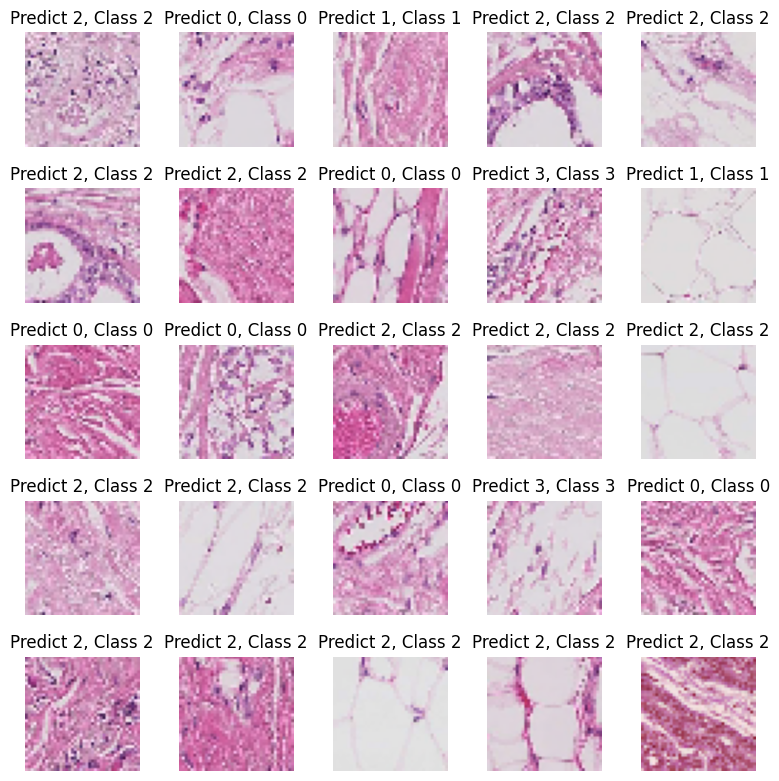



 =============== Incorrect Predicted Samples =============== 

Found 271 incorrect labels


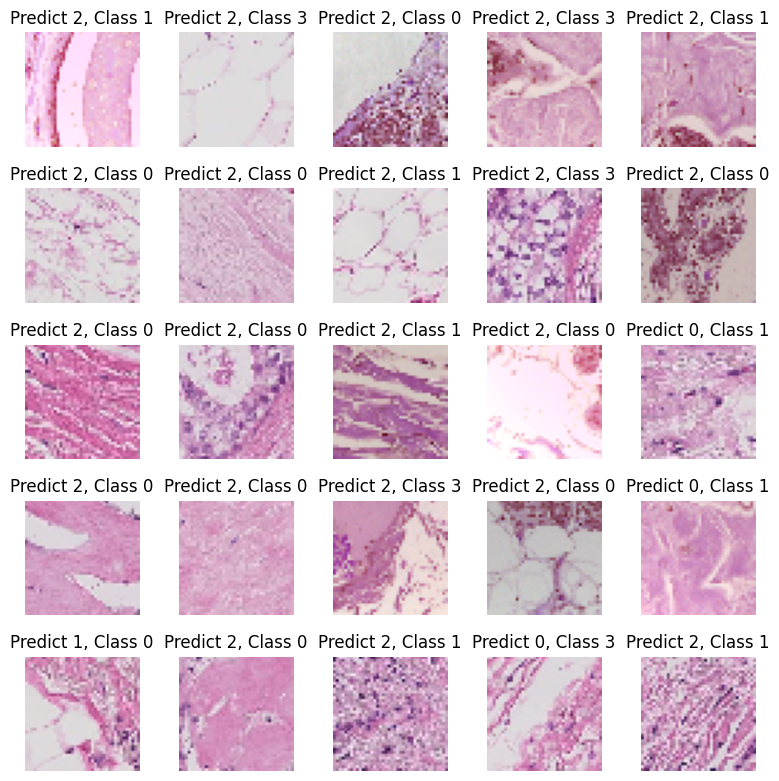



 ===============  Results =============== 
(2085, 4)
(2085, 4)


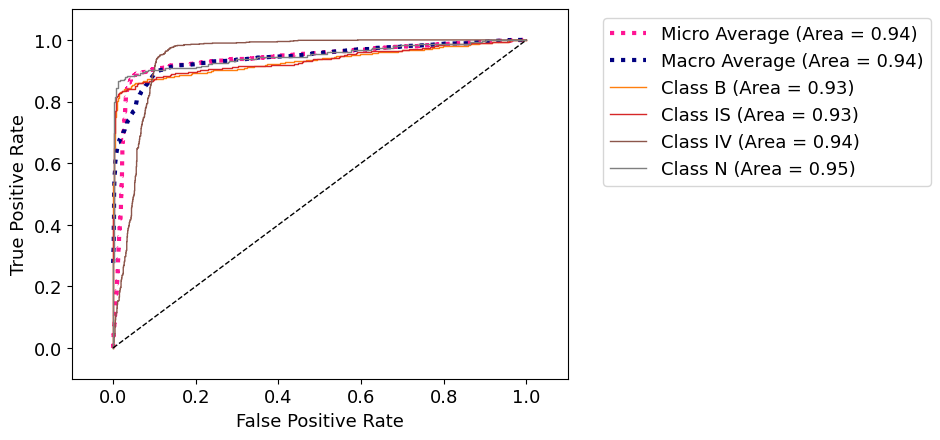

In [24]:
# ORIGINAL ONE
Status = 0
Mode = 1

for Number_of_Hidden_Layers_Input in range(1,2,1):
    for Number_of_Neurons_Input in range(1,2,1):
        for Activation_Function_Input in range(1,2,1):
            gc.collect()

            print('\n\n =============== AE Parameters =============== ')
            print('\nNumber_of_Hidden_Layers_Input: ', Number_of_Hidden_Layers_Input)
            print('Number_of_Neurons_Input: ', Number_of_Neurons_Input)
            print('Activation_Function_Input: ', Activation_Function_Input)

            print('\n\n =============== Classifier Parameters =============== ')
            print('\nLoss: ', loss_a)
            print('Optimizer: ', Optimizer_C)
            print('Batch Size: ', Batch_Size)
            print('Epoch: ', Epochs_C)

            print('\n\n =============== Train Data Dimensions =============== ')
            Size=0.7  # D1

            X_trainS,Y_trainS = X_train_R, Y_train_R
            print('\nFeatures R: ',X_train_R.shape)
            print('Features H: ',X_train_H.shape)
            print('Features L: ',X_train_L.shape)
            print('Feature Labels: ',Y_trainS.shape)

            gpu_model, encoder_r, encoder_h, encoder_l, XX_valid_R,XX_valid_H,XX_valid_L = AE_Train_N(Number_of_Hidden_Layers_Input, Number_of_Neurons_Input, Activation_Function_Input,Path_S,Mode,Status,Epochs,Batch_Size,X_train_R,Y_train_R,X_train_H,X_train_L,num_classes,loss_a,Optimizer_C,Size)

            print('\n\n\t\t =============== Model Summary =============== ')
            print(gpu_model.summary())

            print('\n\n =============== Test Data Dimensions =============== ')
            X_testS,Y_testS = X_test_R_T, Y_test_R_T
            print('\nFeatures R: ',X_test_R_T.shape)
            print('Features H: ',X_test_H_T.shape)
            print('Features L: ',X_test_L_T.shape)
            print('Features Labels: ',Y_testS.shape)

            Batch_Size = 128

            model_history = []  
            cv_scores = []  

            skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)

            # Learning Rate Reducer
            learn_control = ReduceLROnPlateau(monitor=monitor, patience= patience,verbose=verbose,factor=factor, min_lr=min_lr)

            filepath = Path_S + "/D"+ str(option_D0a) + "_weights_best_5Fold_DA_" + str(Number_of_Hidden_Layers_Input) + str(Number_of_Neurons_Input) + str(Activation_Function_Input) + ".hdf5"

            if not (os.path.exists(filepath)):
                checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=verbose, save_best_only=True, mode=mode)
                print('\nNot Using real-time data augmentation.')
                print('Training Starts...')      
                print('X_train Concatenate shape:', X_trainS.shape)
                print('Y_train Concatenate shape:', Y_trainS.shape)                                                                                                                                                                      

                for index, (train_indices, val_indices) in enumerate(skf.split(X_trainS,Y_trainS)):
                    print("\n\n\tTraining on fold " + str(index+1) + "/" + str(kfold_splits) + "...")
                    xtrain_R, xvalid_R = X_trainS[train_indices], X_trainS[val_indices]
                    xtrain_H, xvalid_H = X_train_H[train_indices], X_train_H[val_indices]
                    xtrain_L, xvalid_L = X_train_L[train_indices], X_train_L[val_indices]
                    ytrain_R, yvalid_R = Y_trainS[train_indices], Y_trainS[val_indices]    

                    ytrain = tf.keras.utils.to_categorical(ytrain_R, num_classes)
                    yvalid = tf.keras.utils.to_categorical(yvalid_R, num_classes)        

                    print('\nAfter Applying Categorical Opeartion')
                    print('Train data:', xtrain_R.shape,', Train labels:', ytrain.shape)
                    print('Validation data:', xvalid_R.shape,', Validation labels:', yvalid.shape)

                    print("Mode: ", Mode)
                    with tf.device('/device:GPU:0'):
                        history = gpu_model.fit([xtrain_R,xtrain_H,xtrain_L], ytrain, batch_size=Batch_Size, epochs=Epochs_C, validation_data=([xvalid_R,xvalid_H,xvalid_L], yvalid), verbose=1, callbacks=[learn_control, checkpoint])
                    model_history.append(history)    
                    print('\nEvaluating the Model...')
                    scores = gpu_model.evaluate([xvalid_R,xvalid_H,xvalid_L], yvalid,verbose=0)
                    print("%s: %.2f%%" % (gpu_model.metrics_names[1], scores[1]*100))
                    cv_scores.append(scores[1] * 100)
                    
                    del xtrain_R, xvalid_R, xtrain_H, xvalid_H, xtrain_L, xvalid_L, ytrain, yvalid, ytrain_R, yvalid_R     

                print("\n%s: %.2f%%" % ("Mean Accuracy: ",np.mean(cv_scores)))
                print("%s: %.2f%%" % ("Standard Deviation: +/-", np.std(cv_scores)))
                print("%.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
                print('Estimated Accuracy %.3f (%.3f)' % (np.mean(cv_scores), np.std(cv_scores)))

            else:
            # load the models
                print('\nLoading Saved Models')
                print('Model : ',filepath)
                gpu_model = load_model(filepath)

                
            print("\n")                
            Y_testa_Old = Y_testS
            print('Before Categorical Features : ',Y_testa_Old.shape)

            Y_testS_ = tf.keras.utils.to_categorical(Y_testS, num_classes)      
            print('After Categorical Features : ',Y_testS_.shape)
                
            test_eval = gpu_model.evaluate([X_test_R_T,X_test_H_T,X_test_L_T],Y_testS_, verbose=0)
            
            print('\n\n =============== Overall Average Results =============== ')
            print('\nAccuracy:', test_eval[1])
            
            concat_encoded_output_R_ = encoder_r.predict([X_test_R_T])
            concat_encoded_output_H_ = encoder_h.predict([X_test_H_T])
            concat_encoded_output_L_ = encoder_l.predict([X_test_L_T])

            concat_encoded_output_T_ = np.concatenate((concat_encoded_output_R_,concat_encoded_output_H_,concat_encoded_output_L_), axis=1)
            
            layer_name_ = ['concatenate_1', 'Last_Output_Layer1', 'Last_Output_Layer']
            
            concat_encoded_output_D_3a = Model(inputs=gpu_model.input,outputs=gpu_model.get_layer(layer_name_[2]).output)
            concat_encoded_output_D_3_Tr = concat_encoded_output_D_3a.predict([XX_valid_R,XX_valid_H,XX_valid_L])
            
            concat_encoded_output_D_3b = Model(inputs=gpu_model.input,outputs=gpu_model.get_layer(layer_name_[2]).output)
            concat_encoded_output_D_3_Te = concat_encoded_output_D_3b.predict([X_test_R_T,X_test_H_T,X_test_L_T])

            np.savetxt(Path_S + "/Train_C3" + str(Number_of_Hidden_Layers_Input) + str(Number_of_Neurons_Input) + str(Activation_Function_Input) + ".csv", concat_encoded_output_D_3_Tr, fmt='%5.8g', delimiter=',')
            np.savetxt(Path_S + "/Test_C3" + str(Number_of_Hidden_Layers_Input) + str(Number_of_Neurons_Input) + str(Activation_Function_Input) + ".csv", concat_encoded_output_D_3_Te, fmt='%5.8g', delimiter=',')
            
            np.savetxt(Path_S + "/Train_Labels" + str(Number_of_Hidden_Layers_Input) + str(Number_of_Neurons_Input) + str(Activation_Function_Input) + ".csv", Y_trainS, fmt='%5.8g', delimiter=',')
            np.savetxt(Path_S + "/Test_Labels" + str(Number_of_Hidden_Layers_Input) + str(Number_of_Neurons_Input) + str(Activation_Function_Input) + ".csv", Y_testa_Old, fmt='%5.8g', delimiter=',')
            
            #Predicted Labels
            predicted_classes = gpu_model.predict([X_test_R_T,X_test_H_T,X_test_L_T])
            predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
            test_labels = Y_testS

            print("Sensitivity = ", recall_score(test_labels, predicted_classes, average='weighted'))
            print("Precision = ", precision_score(test_labels, predicted_classes, average='weighted'))
            print("F1 = ", f1_score(test_labels, predicted_classes, average='weighted'))

            print('\n\n =============== Classwise Results =============== ')
            cmat = confusion_matrix(test_labels, predicted_classes) 
            print("\nAccuracy = ", cmat.diagonal()/cmat.sum(axis=1))
            print("Sensitivity = ", recall_score(test_labels, predicted_classes, average=None))
            print("Precision = ", precision_score(test_labels, predicted_classes, average=None))
            print("F1 = ", f1_score(test_labels, predicted_classes, average=None))

            print("\n\n")            
            target_names = ["Class {}".format(ia) for ia in range(num_classes)]
            print(classification_report(test_labels, predicted_classes, target_names=target_names))
            
            with open(Path_S_1 + "/Metrics_Result ICAIR.txt", "a") as myfile:

                myfile.write("\n\n =============== Dataset_" + str(option_D0a) + "=============== ")
                myfile.write("\nAE Configuration: No. of Layers = " + str(Number_of_Hidden_Layers_Input) + ", No. of Neurons = " + str(Number_of_Neurons_Input) + ", Activation No = " + str(Activation_Function_Input) + "\n")                    
                myfile.write("\n =============== Overall Average Results =============== ")
                myfile.write("\nAccuracy: " + str("%.5f" % test_eval[1]))
                myfile.write("\nLoss: " + str("%.5f" % test_eval[0]))
                myfile.write("\nSensitivity: " + str(recall_score(test_labels, predicted_classes, average='weighted')))
                myfile.write("\nPrecision: " + str(precision_score(test_labels, predicted_classes, average='weighted')))
                myfile.write("\nF-1_Score: " + str(f1_score(test_labels, predicted_classes, average='weighted')) + "\n")

                myfile.write("\n =============== Classwise Average Results =============== ")
                myfile.write("\nAccuracy: " + str(cmat.diagonal()/cmat.sum(axis=1)))
                myfile.write("\nSensitivity: " + str(recall_score(test_labels, predicted_classes, average=None)))
                myfile.write("\nPrecision: " + str(precision_score(test_labels, predicted_classes, average=None)))
                myfile.write("\nF-1_Score: " + str(f1_score(test_labels, predicted_classes, average=None)) + "\n")
            
            columns = 16
            work_directory_P = os.getcwd() + "/ResultsPredicted"

            if not os.path.exists(work_directory_P):
                os.mkdir(work_directory_P)

            fig=plt.figure(figsize=(8, 8))

            left  = 0.125  # the left side of the subplots of the figure
            right = 1    # the right side of the subplots of the figure
            bottom = 0.1   # the bottom of the subplots of the figure
            top = 0.9      # the top of the subplots of the figure
            wspace = 0.25   # the amount of width reserved for blank space between subplots
            hspace = 0.25   # the amount of height reserved for white space between subplots

            plt.subplots_adjust( left, bottom, right, top, wspace, hspace)
            columns = 5
            rows = 5
            f = 12
            print('\n\n =============== Correct Predicted Samples =============== ')

            correct = np.where(predicted_classes==test_labels)[0]
            print("\nFound %d correct labels" % len(correct))
            for i1, correct in enumerate(correct[:rows*columns]):
                ax = fig.add_subplot(rows, columns, i1+1)
                plt.imshow(X_testaB[correct].astype('uint8'))
                plt.axis('off')        
                ax.set_title("Predict {}, Class {}".format(predicted_classes[correct], test_labels[correct]), fontsize=f)
                plt.imsave(work_directory_P+'/Correc_D-'+ str(option_D0a) + '_PL-' + str(predicted_classes[correct]) + '_TL-' + str(test_labels[correct]) + '_I-' + str(i1) + '.jpg', X_testaB[correct].astype('uint8'), dpi=fig.dpi)
            plt.tight_layout()
            plt.show()


            fig=plt.figure(figsize=(8, 8))
            plt.subplots_adjust( left, bottom, right, top, wspace, hspace)

            print('\n\n =============== Incorrect Predicted Samples =============== ')

            incorrect = np.where(predicted_classes!=test_labels)[0]
            print("\nFound %d incorrect labels" % len(incorrect))
            for i2, incorrect in enumerate(incorrect[:rows*columns]):
                ax = fig.add_subplot(rows, columns, i2+1)
                plt.imshow(X_testaB[incorrect].astype('uint8'))
                plt.axis('off')        
                ax.set_title("Predict {}, Class {}".format(predicted_classes[incorrect], test_labels[incorrect]), fontsize=f)
                plt.imsave(work_directory_P+'/Incorrect_D-'+ str(option_D0a) + '_PL-' + str(predicted_classes[incorrect]) + '_TL-' + str(test_labels[incorrect]) + '_I-' + str(i2) + '.jpg', X_testaB[incorrect].astype('uint8'), dpi=fig.dpi)
            plt.tight_layout()
            plt.show()

            print('\n\n ===============  Results =============== ')

            y_score = gpu_model.predict([X_test_R_T,X_test_H_T,X_test_L_T])
            y_test = tf.keras.utils.to_categorical(Y_testS, num_classes)      
            print(y_score.shape)
            print(y_test.shape)

            # Plot linewidth.
            lw = 1

            # Compute ROC curve and ROC area for each class
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            for ia in range(num_classes):
                fpr[ia], tpr[ia], _ = roc_curve(y_test[:, ia], y_score[:, ia])
                roc_auc[ia] = auc(fpr[ia], tpr[ia])

            # Compute micro-average ROC curve and ROC area
            fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
            roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

            # Compute macro-average ROC curve and ROC area
            all_fpr = np.unique(np.concatenate([fpr[ib] for ib in range(num_classes)]))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for ic in range(num_classes):
                mean_tpr += interp(all_fpr, fpr[ic], tpr[ic])

            # Finally average it and compute AUC
            mean_tpr /= num_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr
            roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

            # Plot all ROC curves
            plt.figure(1)
            plt.style.use('default')    
            plt.rcParams.update({'font.size': 13})

            plt.plot(fpr["micro"], tpr["micro"],
                     label='Micro Average (Area = {0:0.2f})'
                           ''.format(roc_auc["micro"]),
                     color='deeppink', linestyle=':', linewidth=3)

            plt.plot(fpr["macro"], tpr["macro"],
                     label='Macro Average (Area = {0:0.2f})'
                           ''.format(roc_auc["macro"]),
                     color='navy', linestyle=':', linewidth=3)

            prop_cycle = plt.rcParams['axes.prop_cycle']
            colors = cycle(prop_cycle.by_key()['color'])
            for id, color in zip(range(num_classes), colors):
                if id==0:
                        plt.plot(fpr[id], tpr[id], color=next(colors), lw=lw,
                                 label='Class {0} (Area = {1:0.2f})'
                                 ''.format('B', roc_auc[id]))
                elif id==1:
                    plt.plot(fpr[id], tpr[id], color=next(colors), lw=lw,
                             label='Class {0} (Area = {1:0.2f})'
                             ''.format('IS', roc_auc[id]))
                elif id==2:
                    plt.plot(fpr[id], tpr[id], color=next(colors), lw=lw,
                             label='Class {0} (Area = {1:0.2f})'
                             ''.format('IV', roc_auc[id]))
                elif id==3:
                    plt.plot(fpr[id], tpr[id], color=next(colors), lw=lw,
                             label='Class {0} (Area = {1:0.2f})'
                             ''.format('N', roc_auc[id]))                

            plt.plot([0, 1], [0, 1], 'k--', lw=lw)
            plt.xlim([-0.10, 1.10])
            plt.ylim([-0.10, 1.10])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc='upper right', bbox_to_anchor=(1.75, 1.0))

#             work_directory_R = os.getcwd() + "/Results_ROC"
#             work_directory_C = os.getcwd() + "/Results_CM"

#             if not os.path.exists(work_directory_R):
#                 os.mkdir(work_directory_R)

#             plt.savefig(work_directory_R + '/ROC_D' + str(option_D0a), dpi=1000, bbox_inches="tight")
#             plt.show()

#             if not os.path.exists(work_directory_C):
#                 os.mkdir(work_directory_C)

#             normalize = False
#             plot_cm(test_labels, predicted_classes, option_D0a, normalize, work_directory_C)
            
            del gpu_model, predicted_classes, test_labels
            # ORIGINAL CODE
    


In [34]:
if option_D0a==1:
    path = os.path.join(os.getcwd() + '/Weights_ICIAR/Multi_Balanced/')
    print(path)

    #M
    Number_of_Hidden_Layers_Input=1
    Number_of_Neurons_Input=1
    Activation_Function_Input=1
    num_classes = 4

    names3 = ["Train_C3","Test_C3"]
    namesL = ["Train_Labels","Test_Labels"]

sc = StandardScaler()

def tSNETestC(Number_of_Hidden_Layers_Input,Number_of_Neurons_Input ,Activation_Function_Input,Check):
    i=j=0
    U = 0
    concat_encoded = []

    totalData = []
    if Check == 1:
        names = names1
    elif Check == 2:
        names = names2
    elif Check == 3:
        names = names3
    elif Check == 4:
        names = names4
        
    n = len(names)
    for name in names:
        file = "%s%s%d%d%d.csv" % (path, name, Number_of_Hidden_Layers_Input, Number_of_Neurons_Input, Activation_Function_Input)
        U = U + 1
        print("Appending %s" % file)
        fileN = pd.read_csv(file, header = None)

        if Check==1 or Check==2:
            pca = PCA(n_components=50)
            X_pca = pca.fit_transform(fileN) 
        else:
            X_pca = fileN
                
        totalData.append(X_pca)

    concat_encoded = totalData
    return concat_encoded, n

def tSNETesta(Number_of_Hidden_Layers_Input,Number_of_Neurons_Input ,Activation_Function_Input):
    totalData = []
    n = len(namesL)
    for name in namesL:
        file = "%s%s%d%d%d.csv" % (path, name, Number_of_Hidden_Layers_Input, Number_of_Neurons_Input, Activation_Function_Input)
        print("Appending %s" % file)
        fileN = pd.read_csv(file, header = None)
        print(fileN.shape)

        totalData.append(fileN)

    concat_encoded = totalData

    return concat_encoded, n


D:\Taimoor_Datasets\Paper 2\WSI\Processed_Class_Wise\RESULTS_DIRECTORY_TRAIN_Dart_LUNG\Code_TSNE\Final/Weights_ICIAR/Multi_Balanced/


range(0, 8)
Appending D:\Taimoor_Datasets\Paper 2\WSI\Processed_Class_Wise\RESULTS_DIRECTORY_TRAIN_Dart_LUNG\Code_TSNE\Final/Weights_ICIAR/Multi_Balanced/Train_Labels111.csv
(8340, 1)
Appending D:\Taimoor_Datasets\Paper 2\WSI\Processed_Class_Wise\RESULTS_DIRECTORY_TRAIN_Dart_LUNG\Code_TSNE\Final/Weights_ICIAR/Multi_Balanced/Test_Labels111.csv
(2085, 1)

Check:  3
Appending D:\Taimoor_Datasets\Paper 2\WSI\Processed_Class_Wise\RESULTS_DIRECTORY_TRAIN_Dart_LUNG\Code_TSNE\Final/Weights_ICIAR/Multi_Balanced/Train_C3111.csv
Appending D:\Taimoor_Datasets\Paper 2\WSI\Processed_Class_Wise\RESULTS_DIRECTORY_TRAIN_Dart_LUNG\Code_TSNE\Final/Weights_ICIAR/Multi_Balanced/Test_C3111.csv
2
(10425, 4)
No:  0
[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 10425 samples in 0.015s...
[t-SNE] Computed neighbors for 10425 samples in 0.256s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10425
[t-SNE] Computed conditional probabilities for sample 2000 / 10425
[t-SNE] Computed cond

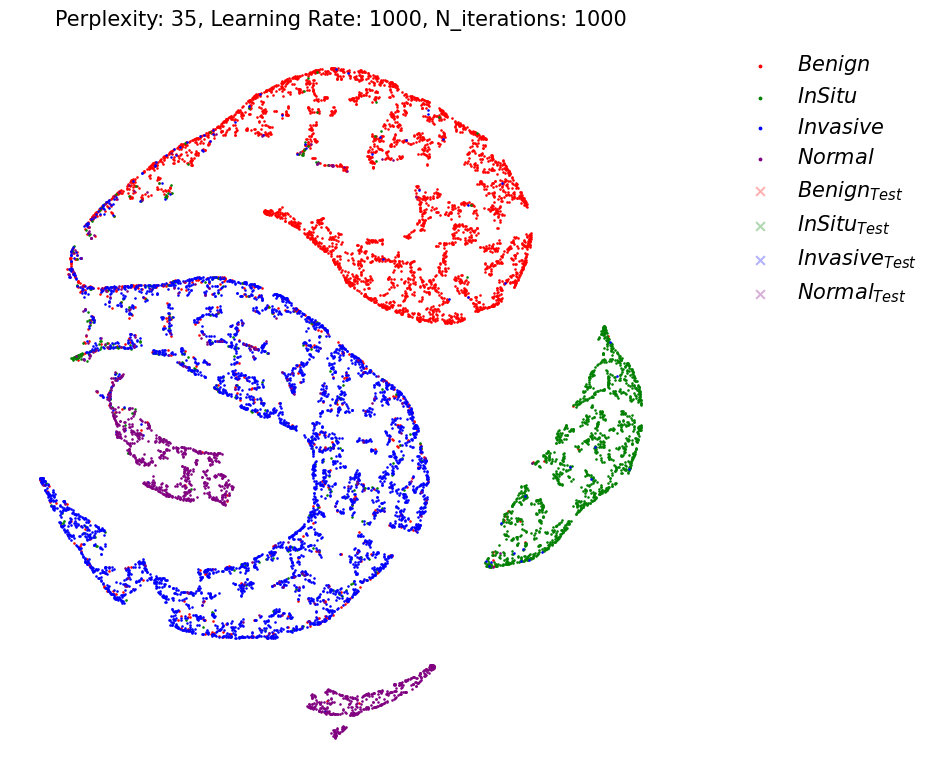

In [35]:
if option_D0a==1:
    classes = ['Benign', 'InSitu', 'Invasive','Normal','Benign', 'InSitu', 'Invasive','Normal'] # the same order as labels 0,1,2,3
    T = ["$\mathit{Benign}$","$\mathit{InSitu}$","$\mathit{Invasive}$","$\mathit{Normal}$","$\mathit{Benign_{Test}}$","$\mathit{InSitu_{Test}}$","$\mathit{Invasive_{Test}}$","$\mathit{Normal_{Test}}$"]

lr = [1000]
itera = [1000]
perplexities = [35]
s = [2]

target_ids = range(len(classes))
print(target_ids)

labels , n = tSNETesta(Number_of_Hidden_Layers_Input,Number_of_Neurons_Input ,Activation_Function_Input)

labels_ = np.concatenate((labels[:]), axis=0)

labels = np.asarray(labels_).ravel()

if option_D0a==1:
#     ListChecK = [1,2,3]
    ListChecK = [3]

for iC in ListChecK:
    
    Check = iC
    print("\nCheck: ",Check)
    concat_encoded, n = tSNETestC(Number_of_Hidden_Layers_Input,Number_of_Neurons_Input ,Activation_Function_Input,Check)
    
    concat_encoded_ = np.concatenate((concat_encoded[:]), axis=0)
    print(n)
    print(concat_encoded_.shape)
    
    q = 0
    for i3, lr in enumerate(lr):
        for i2, itera in enumerate(itera):
            for i1, perplexity in enumerate(perplexities):
                print('No: ',q)
                q = q + 1
                t0 = time()
                model = TSNE(n_components=2, random_state=0, init='random', perplexity=perplexity,learning_rate = lr, n_iter = itera, verbose=1)

                X_2d = model.fit_transform(concat_encoded_)
#                 print(X_2d.shape)
                
                t1 = time()
                print("circles, perplexity=%d in %.2g sec" % (perplexity, t1 - t0))

                fig = plt.figure(figsize=(10, 8))

                if option_D0a==1:
                    markers = [".", ".", ".", ".", 'x','x','x','x']
                    colors = ["red", "green", "blue", "purple", "red", "green", "blue", "purple"]
                    
                    X_ = X_2d[25772:] 
                    labels_ = labels[25772:].ravel()
                    
                    X_a = X_2d[:25772] 
                    labels_a = labels[:25772].ravel()
    

                for i, c, label, markers in zip(target_ids, colors, classes, markers):
                    if i>=4 and i<=8:
                        s = [10]
#                         print(i)
                        plt.scatter(X_[labels_ == i-4, 0], X_[labels_ == i-4, 1], c=c, s=s, label=label, marker=markers, alpha=0.3)
                    else:
                        s = [3]
#                         print(i)
                        plt.scatter(X_a[labels_a == i, 0], X_a[labels_a == i, 1], c=c, s=s, label=label, marker=markers)
                        
                f = 15
                plt.axis('off')        
                plt.title('Perplexity: %d, Learning Rate: %d, N_iterations: %d' % (perplexity,lr,itera), fontsize=f)
                plt.legend(T , frameon=False, fontsize=f, markerscale=2, scatterpoints=1, ncol=1, loc='upper right', bbox_to_anchor=(1.40, 1))
                plt.tight_layout()
                plt.show()

                fig.savefig('./Result_Combine_D1_B_Classifier_Final_' + str(iC) + '_' + str(lr) + '_' + str(itera) + '_' + str(perplexity) +'.png', bbox_inches="tight")
